### 概率与似然

- probability vs. likelihood
    - 概率：P(数据 | 参数)
        - 在**已知模型参数**的情况下，某个特定结果或事件发生的可能性。
        - 已知一枚硬币是公平的（正反面概率都是50%），那么抛出正面的概率是0.5。
    - 似然：L(参数 | 数据)
        - 在观察到特定数据的情况下，模型参数取特定值的支持程度。
        - 观察到连续10次抛硬币都是正面，我们想知道这枚硬币是偏向正面的可能性有多大。
- 以LLM为例
    - 训练阶段（似然）：
        - 在训练GPT模型时，模型通过调整内部参数，使得训练数据的似然最大化。这意味着模型会“学习”如何生成与训练数据分布相似的文本。
    - 生成阶段（概率）：
        - 当模型生成文本时，它使用训练好的参数，基于当前的输入（上下文），计算下一个词的概率分布，并根据这些概率进行采样，从而生成连贯的文本。

### MLE

$$
\theta = \underset{\theta}{\mathrm{argmax}}\ p_{\theta}(x) = \underset{\theta}{\mathrm{argmax}}\ \log p_{\theta}(x)
$$

- 训练集 $X=\left\{x_1,x_2,\cdots, x_N\right\}$，则 marginal log likelihood（$\log p_\theta(X)$）

    $$
    \begin{split}
    \log p_{\theta}(X) &= \log \prod_{i=1}^{N} p_{\theta}(x_i) \\
    &= \sum_{i=1}^{N} \log p_{\theta}(x_{i}) \\
    &= \sum_{i=1}^{N} \log \int p_{\theta}(x_i, z_i)dz \\
    &= \sum_{i=1}^{N} \log \int p_{\theta}(x_i \lvert z_i)p_{\theta}(z_i)dz
    \end{split}
    $$
    - $z$ 的维度，决定了最后有几重积分；

### （MLE）估计正态分布的参数 $\mu, \sigma$

In [3]:
import numpy as np
from scipy.optimize import minimize

# 生成正态分布的样本数据
np.random.seed(0)
true_mu, true_sigma = 0, 0.1  # 真实的均值和标准差
samples = np.random.normal(true_mu, true_sigma, 1000)

# 定义对数似然函数
def log_likelihood(params, data):
    mu, sigma = params
    return -np.sum(np.log(np.sqrt(2 * np.pi * sigma**2)) + ((data - mu)**2 / (2 * sigma**2)))

# 定义初始参数估计
initial_params = [0, 1]  # 初始猜测的均值和标准差

# 使用梯度下降法找到最大化对数似然函数的参数值
result = minimize(lambda params: -log_likelihood(params, samples), initial_params, method='BFGS')

estimated_mu, estimated_sigma = result.x
result.x

array([-0.00452568,  0.09870331])

### language modeling

$$
-\log P
$$
- 训练损失的下降表示模型在逐步最大化似然，即模型参数在调整以更好地解释训练数据。
- 交叉熵损失等价于负对数似然，最小化损失即最大化似然。

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
corpus = [
    "hello how are you",
    "i am fine thank you",
    "how about you",
    "i am doing well",
    "thank you very much"
]

In [9]:
word_list = " ".join(corpus).split()
vocab = list(set(word_list))
word2idx = {w: idx for idx, w in enumerate(vocab)}
idx2word = {idx: w for idx, w in enumerate(vocab)}
vocab_size = len(vocab)
vocab_size, word2idx

(13,
 {'you': 0,
  'very': 1,
  'thank': 2,
  'fine': 3,
  'hello': 4,
  'am': 5,
  'well': 6,
  'are': 7,
  'how': 8,
  'doing': 9,
  'much': 10,
  'about': 11,
  'i': 12})

In [5]:
def make_dataset(corpus):
    input_data = []
    target_data = []
    for sentence in corpus:
        words = sentence.split()
        for i in range(len(words)-1):
            input_data.append(word2idx[words[i]])
            target_data.append(word2idx[words[i+1]])
    return input_data, target_data

inputs, targets = make_dataset(corpus)
inputs, targets 

([4, 8, 7, 12, 5, 3, 2, 8, 11, 12, 5, 9, 2, 0, 1],
 [8, 7, 0, 5, 3, 2, 0, 11, 0, 5, 9, 6, 0, 1, 10])

In [6]:
inputs = torch.LongTensor(inputs)
targets = torch.LongTensor(targets)

In [7]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=10):
        super(LanguageModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, x):
        x = self.embed(x)  # [batch_size, embedding_dim]
        out = self.fc(x)   # [batch_size, vocab_size]
        return out

model = LanguageModel(vocab_size)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

losses = []

# 训练模型
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

Epoch [20/100], Loss: 1.7597
Epoch [40/100], Loss: 1.2261
Epoch [60/100], Loss: 0.9018
Epoch [80/100], Loss: 0.6894
Epoch [100/100], Loss: 0.5475


In [13]:
np.log(vocab_size)

2.5649493574615367

Text(0.5, 1.0, 'Training Loss over Epochs (Negative Log-Likelihood)')

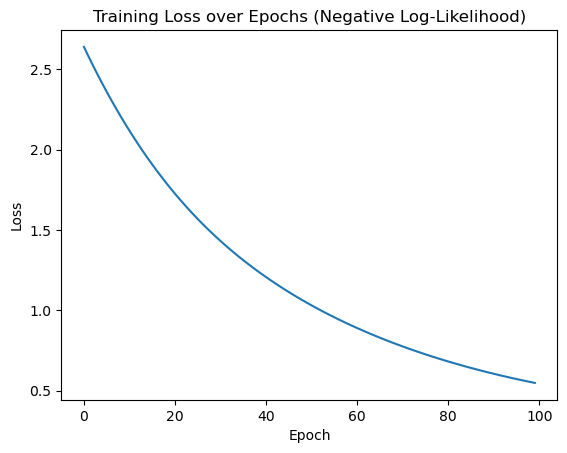

In [14]:
plt.plot(range(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs (Negative Log-Likelihood)")

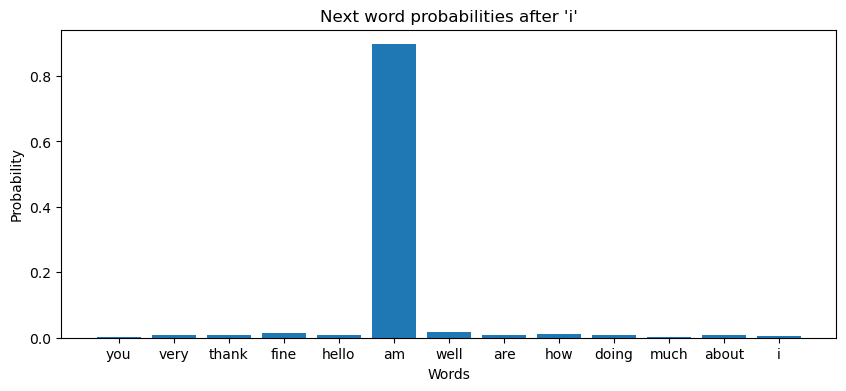

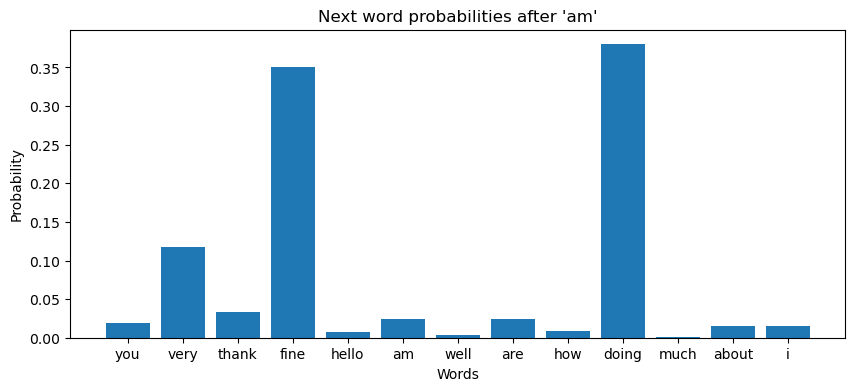

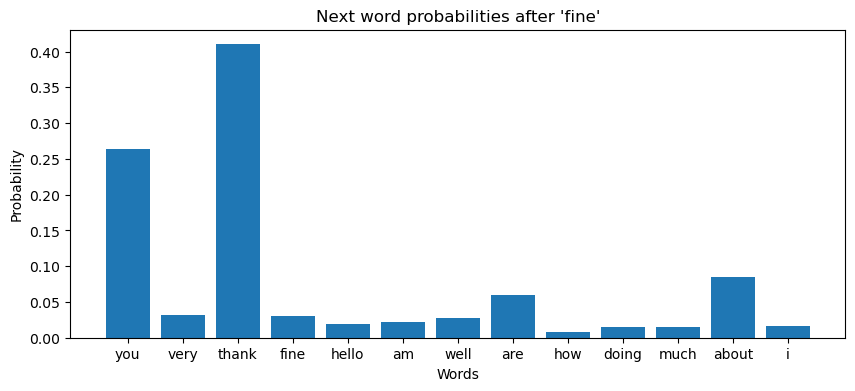

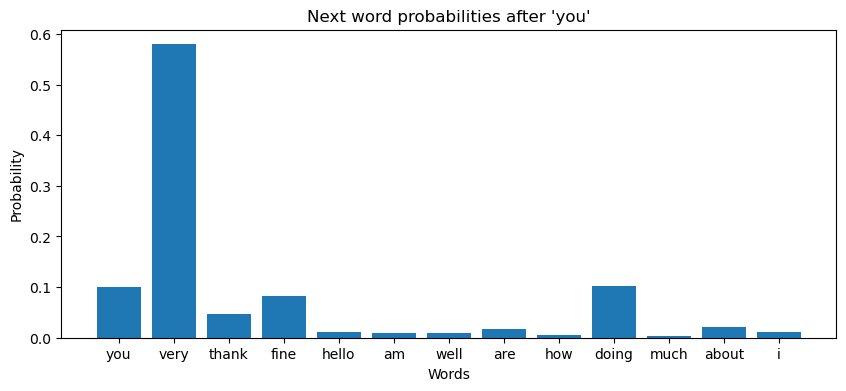

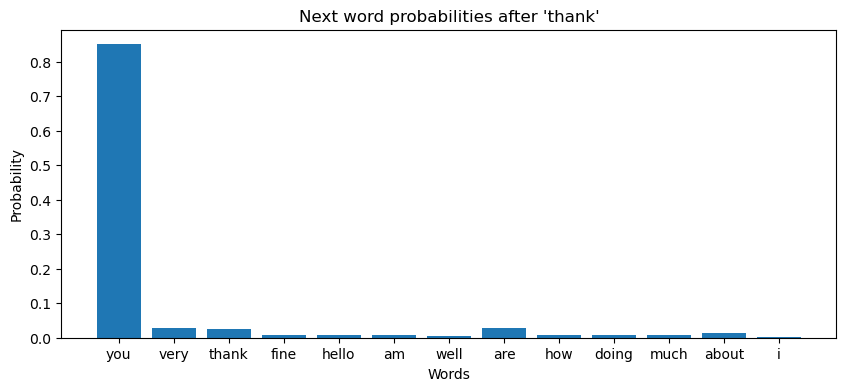

'i am fine you thank you'

In [15]:
def generate_text(model, start_word, idx2word, word2idx, max_len=5):
    model.eval()
    words = [start_word]
    input_word = torch.LongTensor([word2idx[start_word]])
    with torch.no_grad():
        for _ in range(max_len):
            output = model(input_word)
            # 计算概率分布
            probabilities = torch.softmax(output, dim=1)
            # 可视化概率分布
            probs = probabilities.squeeze().cpu().numpy()
            plt.figure(figsize=(10,4))
            plt.bar([idx2word[i] for i in range(vocab_size)], probs)
            plt.xlabel("Words")
            plt.ylabel("Probability")
            plt.title(f"Next word probabilities after '{words[-1]}'")
            plt.show()
            # 采样下一个词
            predicted_idx = torch.multinomial(probabilities, 1).item()
            predicted_word = idx2word[predicted_idx]
            words.append(predicted_word)
            input_word = torch.LongTensor([predicted_idx])
    return ' '.join(words)

start_word = 'i'
generated_sentence = generate_text(model, start_word, idx2word, word2idx)
generated_sentence